In [41]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [13]:
# Load datasets
clean_path = '4000_0.05_clean.csv'
dirty_path = '4000_0.05_dirty.csv'

clean_df = pd.read_csv(clean_path)
dirty_df = pd.read_csv(dirty_path)

# Display basic info about the datasets
# print('Clean Data Info:')
# print(clean_df.info())
# print('\nDirty Data Info:')
# print(dirty_df.info())

# Check the first few rows of the datasets
# print('\nClean Data Sample:')
# print(clean_df.head())
# print('\nDirty Data Sample:')
# print(dirty_df.head())

In [26]:
# Prepare Data: target variable y is the binary classification of NATIVITY (whether a person is Native or Foreign-born)
# The sensitive attribute RAC1P (likely race or ethnicity) is separated out to evaluate fairness
def prepare_data(df, is_clean=True):
    if is_clean:
        df = df.iloc[:, :-8] # Dropping the last 8 columns of the clean dataset
    X = df.drop(['NATIVITY', 'RAC1P'], axis=1)
    y = (df['NATIVITY'] == 1).astype(int) # Binary classification: 1 if Native, 0 if Foreign-born
    sensitive_attr = df['RAC1P']
    X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(X, y, sensitive_attr, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test, s_train, s_test

In [27]:
# Prepare training and testing sets: data is split into training and testing sets, along with the sensitive attribute.
X_train_clean, X_test_clean, y_train_clean, y_test_clean, s_train_clean, s_test_clean = prepare_data(clean_df, is_clean=True)
X_train_dirty, X_test_dirty, y_train_dirty, y_test_dirty, s_train_dirty, s_test_dirty = prepare_data(dirty_df, is_clean=False)

In [29]:
# Fairness Metrics
def demographic_parity(y_pred, sensitive_attr): # Measures whether the prediction rates are equal across different race groups
    groups = sensitive_attr.unique()
    rates = {group: (y_pred[sensitive_attr == group].mean()) for group in groups}
    return rates

def equalized_odds(y_true, y_pred, sensitive_attr): # Measures whether true positive rates and false positive rates are equal across race groups
    groups = sensitive_attr.unique()
    true_positive_rates = {}
    false_positive_rates = {}

    for group in groups:
        y_true_group = y_true[sensitive_attr == group]
        y_pred_group = y_pred[sensitive_attr == group]
        
        tp = ((y_pred_group == 1) & (y_true_group == 1)).sum()
        tn = ((y_pred_group == 0) & (y_true_group == 0)).sum()
        fp = ((y_pred_group == 1) & (y_true_group == 0)).sum()
        fn = ((y_pred_group == 0) & (y_true_group == 1)).sum()
        
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        
        true_positive_rates[group] = tpr
        false_positive_rates[group] = fpr

    return true_positive_rates, false_positive_rates

def disparate_impact_ratio(y_pred, sensitive_attr): # Ratio of the minimum prediction rate to the maximum prediction rate across groups
    groups = sensitive_attr.unique()
    rates = {group: (y_pred[sensitive_attr == group].mean()) for group in groups}
    min_rate = min(rates.values())
    max_rate = max(rates.values())
    return min_rate / max_rate if max_rate > 0 else 0

def statistical_parity_difference(y_pred, sensitive_attr): # Difference between the maximum and minimum prediction rates across groups
    groups = sensitive_attr.unique()
    rates = {group: (y_pred[sensitive_attr == group].mean()) for group in groups}
    max_rate = max(rates.values())
    min_rate = min(rates.values())
    return max_rate - min_rate

In [21]:
# Train models
logreg_clean = LogisticRegression(max_iter=1000)
logreg_clean.fit(X_train_clean, y_train_clean)
y_pred_clean = logreg.predict(X_test_clean)

logreg_dirty = LogisticRegression(max_iter=1000)
logreg_dirty.fit(X_train_dirty, y_train_dirty)
y_pred_dirty = logreg.predict(X_test_dirty)

tree_clean = DecisionTreeClassifier()
tree_clean.fit(X_train_clean, y_train_clean)
y_pred_tree_clean = tree.predict(X_test_clean)

tree_dirty = DecisionTreeClassifier()
tree_dirty.fit(X_train_dirty, y_train_dirty)
y_pred_tree_dirty = tree.predict(X_test_dirty)

rf_clean = RandomForestClassifier()
rf_clean.fit(X_train_clean, y_train_clean)
y_pred_rf_clean = rf_clean.predict(X_test_clean)

rf_dirty = RandomForestClassifier()
rf_dirty.fit(X_train_dirty, y_train_dirty)
y_pred_rf_dirty = rf_dirty.predict(X_test_dirty)

svm_clean = SVC()
svm_clean.fit(X_train_clean, y_train_clean)
y_pred_svm_clean = svm_clean.predict(X_test_clean)

svm_dirty = SVC()
svm_dirty.fit(X_train_dirty, y_train_dirty)
y_pred_svm_dirty = svm_dirty.predict(X_test_dirty)

In [40]:
# Evaluate performance
print('Logistic Regression Accuracy (Clean):', accuracy_score(y_test_clean, y_pred_clean))
print('Decision Tree Accuracy (Clean):', accuracy_score(y_test_clean, y_pred_tree_clean))
print('Random Forest Accuracy (Clean):', accuracy_score(y_test_clean, y_pred_rf_clean))
print('SVM Accuracy (Clean):', accuracy_score(y_test_clean, y_pred_svm_clean))

print('Logistic Regression Accuracy (Dirty):', accuracy_score(y_test_dirty, y_pred_dirty))
print('Decision Tree Accuracy (Dirty):', accuracy_score(y_test_dirty, y_pred_tree_dirty))
print('Random Forest Accuracy (Dirty):', accuracy_score(y_test_dirty, y_pred_rf_dirty))
print('SVM Accuracy (Dirty):', accuracy_score(y_test_dirty, y_pred_svm_dirty))

Logistic Regression Accuracy (Clean): 0.99875
Decision Tree Accuracy (Clean): 1.0
Random Forest Accuracy (Clean): 1.0
SVM Accuracy (Clean): 0.85
Logistic Regression Accuracy (Dirty): 0.9125
Decision Tree Accuracy (Dirty): 0.93
Random Forest Accuracy (Dirty): 0.93625
SVM Accuracy (Dirty): 0.84125


The drop in accuracy for both models when moving from the clean to dirty dataset indicates that the functional dependency violations (data corruption) in the dirty dataset negatively impacted model performance.

In [28]:
# Evaluate fairness metrics
print('Fairness Metrics for Clean Dataset')
print('Demographic Parity (Logistic Regression):', demographic_parity(y_pred_clean, s_test_clean))
print('Equalized Odds (Logistic Regression):', equalized_odds(y_test_clean, y_pred_clean, s_test_clean))
print('Disparate Impact Ratio (Logistic Regression):', disparate_impact_ratio(y_pred_clean, s_test_clean))
print('Statistical Parity Difference (Logistic Regression):', statistical_parity_difference(y_pred_clean, s_test_clean))

print('Fairness Metrics for Dirty Dataset')
print('Demographic Parity (Logistic Regression):', demographic_parity(y_pred_dirty, s_test_dirty))
print('Equalized Odds (Logistic Regression):', equalized_odds(y_test_dirty, y_pred_dirty, s_test_dirty))
print('Disparate Impact Ratio (Logistic Regression):', disparate_impact_ratio(y_pred_dirty, s_test_dirty))
print('Statistical Parity Difference (Logistic Regression):', statistical_parity_difference(y_pred_dirty, s_test_dirty))

Fairness Metrics for Clean Dataset
Demographic Parity (Logistic Regression): {1: 0.9519230769230769, 9: 0.7530864197530864, 2: 0.8904109589041096, 8: 0.62, 6: 0.27692307692307694, 7: 1.0, 3: 1.0, 5: 0.5}
Equalized Odds (Logistic Regression): ({1: 1.0, 9: 1.0, 2: 1.0, 8: 0.96875, 6: 1.0, 7: 1.0, 3: 1.0, 5: 1.0}, {1: 0.0, 9: 0.0, 2: 0.0, 8: 0.0, 6: 0.0, 7: 0, 3: 0, 5: 0.0})
Disparate Impact Ratio (Logistic Regression): 0.27692307692307694
Statistical Parity Difference (Logistic Regression): 0.7230769230769231
Fairness Metrics for Dirty Dataset
Demographic Parity (Logistic Regression): {3: 0.7777777777777778, 1: 0.9329268292682927, 9: 0.7530864197530864, 2: 0.8607594936708861, 8: 0.6842105263157895, 6: 0.4444444444444444, 7: 0.75, 5: 0.75, 4: 0.5}
Equalized Odds (Logistic Regression): ({3: 0.875, 1: 0.9632034632034632, 9: 0.9076923076923077, 2: 0.9682539682539683, 8: 0.925, 6: 0.8888888888888888, 7: 1.0, 5: 1.0, 4: 0.6}, {3: 0.0, 1: 0.4666666666666667, 9: 0.125, 2: 0.4375, 8: 0.1176470588

## Analysis of Results

### Demographic Parity:
In both datasets, prediction rates vary significantly across racial groups. In the clean data, groups 7 and 3 have 100% prediction rate while group 6 has only 28%. The dirty data shows less extreme variations, with rates between 44% and 93%.

### Equalized Odds
In the clean dataset, the true positive rates (TPR) are quite similar for all groups (around 1.0 for most groups), and false positive rates (FPR) are mostly 0. For the dirty dataset, the TPRs and FPRs deviate more between groups, indicating increased bias introduced by the data corruption.

### Disparate Impact Ratio
The clean dataset shows a disparate impact ratio of around 0.28, indicating significant disparity in prediction rates between the most and least favored groups. The dirty dataset shows an improved disparate impact ratio of around 0.48, but still reflects inequality.

### Statistical Parity Difference
The clean dataset has a parity difference of around 0.72, showing a noticeable discrepancy in positive prediction rates between different groups. The dirty dataset shows a smaller but still substantial disparity (0.49), suggesting that while the data corruption may slightly reduce the bias, it does not eliminate it.

## Summary

The dirty data (with functional dependency violations) significantly reduces model accuracy, but interestingly shows improved fairness metrics in some ways. Both datasets show substantial disparities across racial groups: the clean data has perfect classification accuracy but shows greater disparity between groups, the dirty data has lower accuracy but somewhat reduced disparities. Decision Trees are slightly more robust to the data quality issues than Logistic Regression. A potential explantaion for these results are that the functional dependency violations in the dirty data may have disrupted some of the patterns that led to the extreme disparities in the clean data, inadvertently reducing some fairness metrics while decreasing overall accuracy. This suggests an important trade-off between model accuracy and fairness metrics, highlighting the complex relationship between data quality and algorithmic fairness.

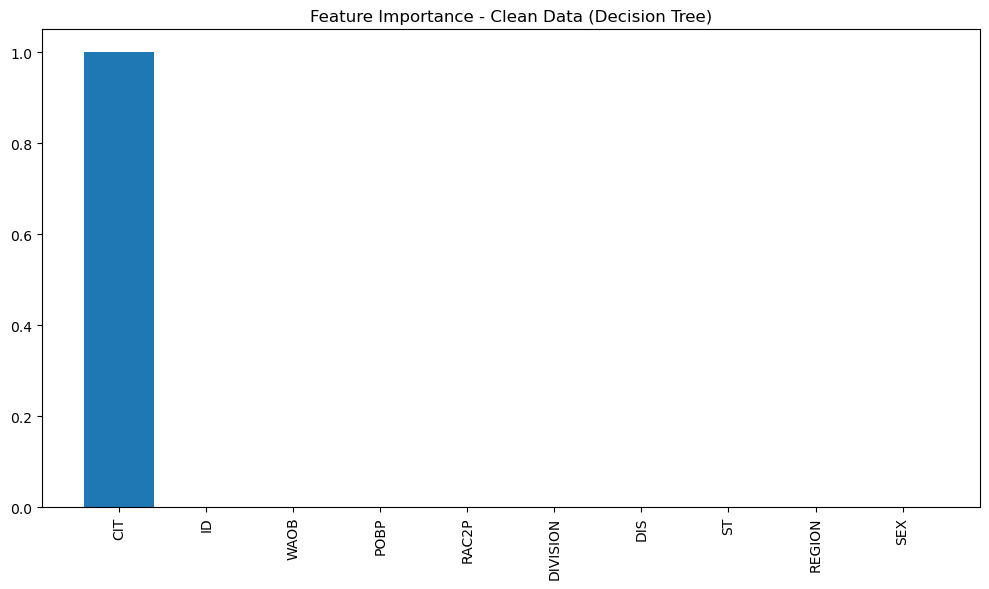

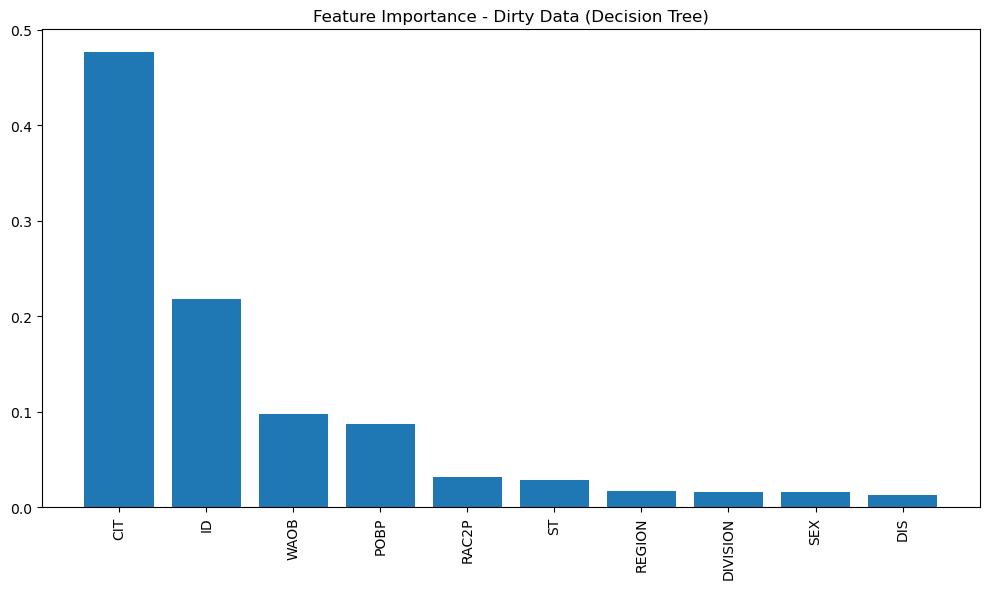

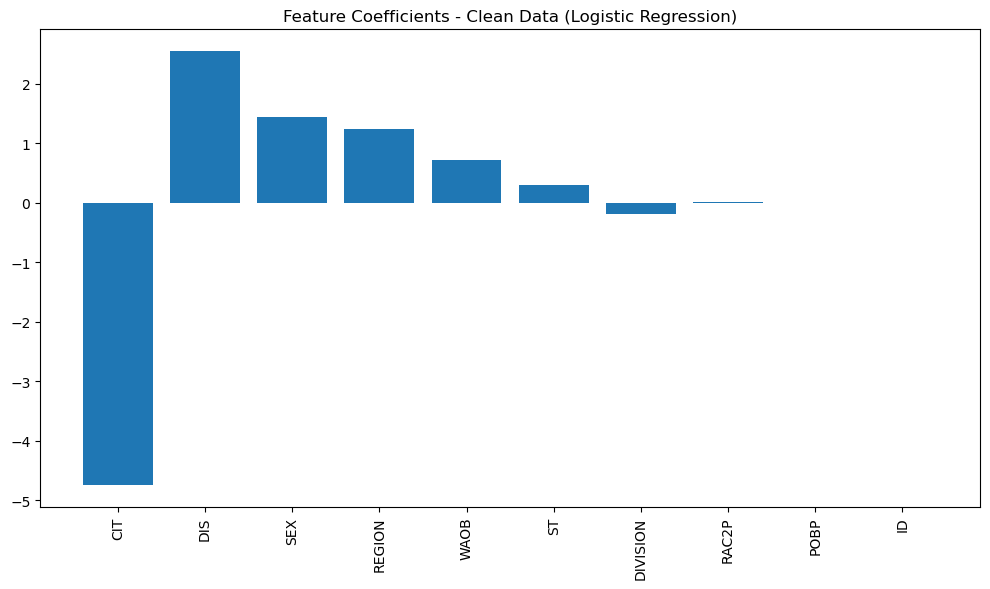

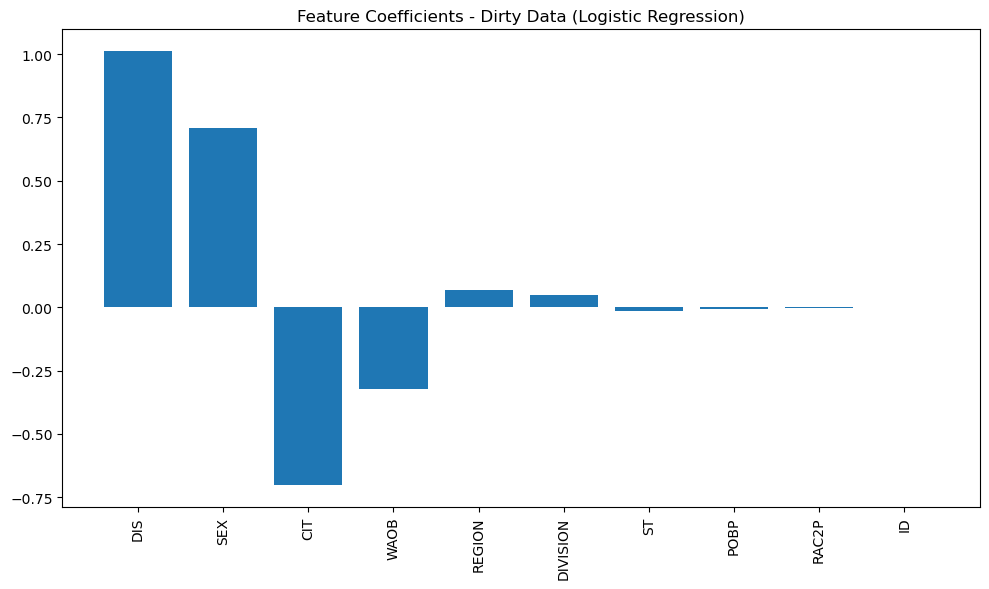

In [32]:
# For decision trees
def plot_feature_importance(model, feature_names, title):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.bar(range(len(indices)), importances[indices], align='center')
    plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()
    
    # Return top 5 features and their importance
    top_features = [(feature_names[i], importances[i]) for i in indices[:5]]
    return top_features

# For logistic regression
def plot_logistic_coefficients(model, feature_names, title):
    coef = model.coef_[0]
    indices = np.argsort(np.abs(coef))[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.bar(range(len(indices)), coef[indices], align='center')
    plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()
    
    # Return top 5 features and their coefficients
    top_features = [(feature_names[i], coef[i]) for i in indices[:5]]
    return top_features

# Use these to compare feature importance between clean and dirty data
clean_feature_names = X_train_clean.columns
dirty_feature_names = X_train_dirty.columns

tree_clean_features = plot_feature_importance(tree_clean, clean_feature_names, "Feature Importance - Clean Data (Decision Tree)")
tree_dirty_features = plot_feature_importance(tree_dirty, dirty_feature_names, "Feature Importance - Dirty Data (Decision Tree)")

logreg_clean_features = plot_logistic_coefficients(logreg_clean, clean_feature_names, "Feature Coefficients - Clean Data (Logistic Regression)")
logreg_dirty_features = plot_logistic_coefficients(logreg_dirty, dirty_feature_names, "Feature Coefficients - Dirty Data (Logistic Regression)")

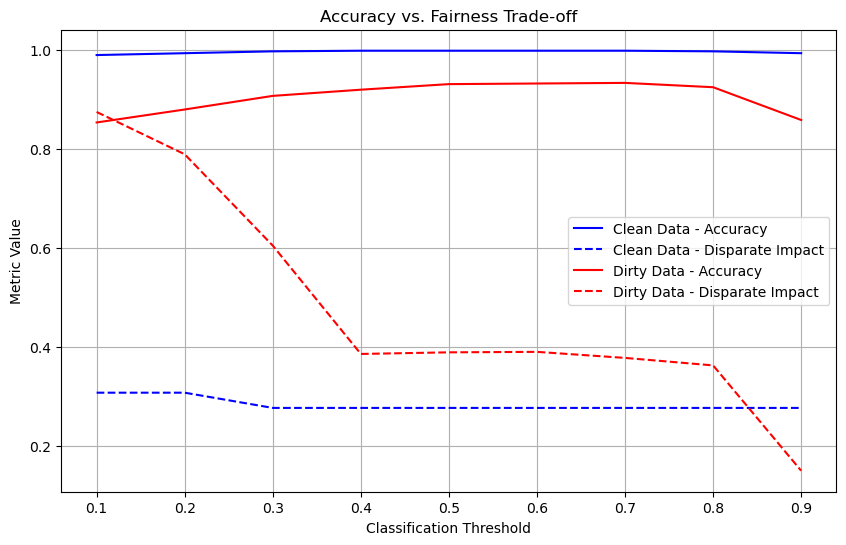

In [33]:
# Evaluate fairness metrics for different prediction thresholds
def fairness_by_threshold(model, X_test, y_test, sensitive_attr, thresholds=None):
    if thresholds is None:
        thresholds = np.linspace(0.1, 0.9, 9)
    
    results = {}
    
    for threshold in thresholds:
        y_prob = model.predict_proba(X_test)[:, 1]
        y_pred = (y_prob >= threshold).astype(int)
        
        dp = demographic_parity(y_pred, sensitive_attr)
        tpr, fpr = equalized_odds(y_test, y_pred, sensitive_attr)
        di = disparate_impact_ratio(y_pred, sensitive_attr)
        spd = statistical_parity_difference(y_pred, sensitive_attr)
        
        # Calculate accuracy at this threshold
        acc = accuracy_score(y_test, y_pred)
        
        results[threshold] = {
            'accuracy': acc,
            'demographic_parity': dp,
            'equalized_odds_tpr': tpr,
            'equalized_odds_fpr': fpr,
            'disparate_impact': di,
            'statistical_parity_diff': spd
        }
    
    return results

# Apply to both models on both datasets
logreg_clean_thresholds = fairness_by_threshold(logreg_clean, X_test_clean, y_test_clean, s_test_clean)
logreg_dirty_thresholds = fairness_by_threshold(logreg_dirty, X_test_dirty, y_test_dirty, s_test_dirty)

# Plot the trade-off between accuracy and fairness metrics
thresholds = list(logreg_clean_thresholds.keys())
clean_acc = [logreg_clean_thresholds[t]['accuracy'] for t in thresholds]
clean_di = [logreg_clean_thresholds[t]['disparate_impact'] for t in thresholds]
dirty_acc = [logreg_dirty_thresholds[t]['accuracy'] for t in thresholds]
dirty_di = [logreg_dirty_thresholds[t]['disparate_impact'] for t in thresholds]

plt.figure(figsize=(10, 6))
plt.plot(thresholds, clean_acc, 'b-', label='Clean Data - Accuracy')
plt.plot(thresholds, clean_di, 'b--', label='Clean Data - Disparate Impact')
plt.plot(thresholds, dirty_acc, 'r-', label='Dirty Data - Accuracy')
plt.plot(thresholds, dirty_di, 'r--', label='Dirty Data - Disparate Impact')
plt.xlabel('Classification Threshold')
plt.ylabel('Metric Value')
plt.title('Accuracy vs. Fairness Trade-off')
plt.legend()
plt.grid(True)
plt.show()

/Users/anikamitra/anaconda3/envs/compsci527/lib/python3.11/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/anikamitra/anaconda3/envs/compsci527/lib/python3.11/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


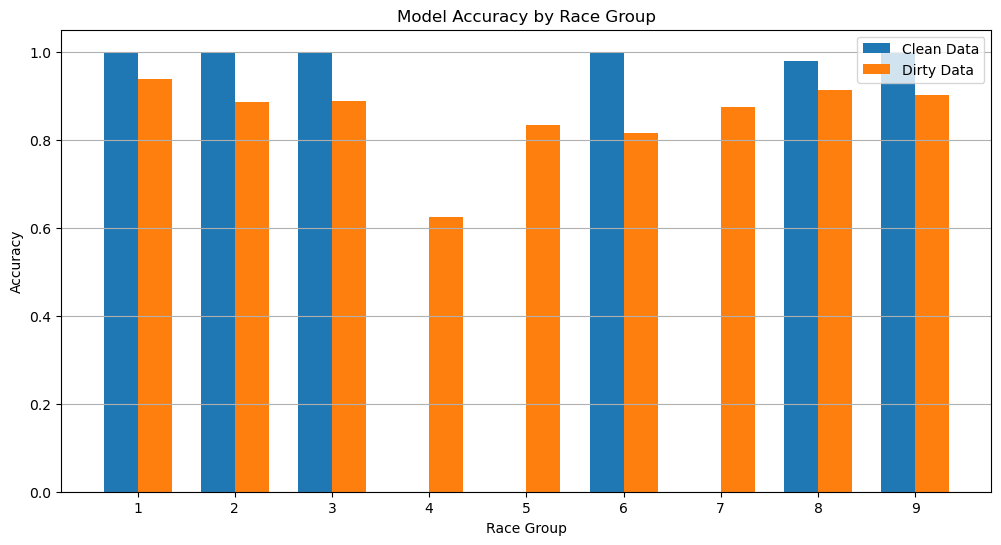

In [35]:
# Function to analyze model performance by group
# 1: White alone, 2: Black or African American alone, 3: American Indian or Alaska Native alone, 4: Chinese alone, 5: Japanese alone
# 6: Other Asian or Pacific Islander alone, 7: Other race alone, 8: Two or more races, 9: Asian Indian alone
def analyze_by_group(y_true, y_pred, sensitive_attr):
    groups = sensitive_attr.unique()
    results = {}
    
    for group in groups:
        mask = (sensitive_attr == group)
        y_true_group = y_true[mask]
        y_pred_group = y_pred[mask]
        
        # Skip groups with too few samples
        if len(y_true_group) < 5:
            continue
        
        results[group] = {
            'accuracy': accuracy_score(y_true_group, y_pred_group),
            'group_size': len(y_true_group),
            'percent_positive_predictions': y_pred_group.mean() * 100,
            'percent_positive_actual': y_true_group.mean() * 100,
            'confusion_matrix': confusion_matrix(y_true_group, y_pred_group).tolist()
        }
    
    return results

# Apply to both models on both datasets
logreg_clean_by_group = analyze_by_group(y_test_clean, y_pred_clean, s_test_clean)
logreg_dirty_by_group = analyze_by_group(y_test_dirty, y_pred_dirty, s_test_dirty)
tree_clean_by_group = analyze_by_group(y_test_clean, y_pred_tree_clean, s_test_clean)
tree_dirty_by_group = analyze_by_group(y_test_dirty, y_pred_tree_dirty, s_test_dirty)

# Plot accuracy by group and dataset
groups = sorted(set(logreg_clean_by_group.keys()) | set(logreg_dirty_by_group.keys()))
clean_acc_by_group = [logreg_clean_by_group.get(g, {}).get('accuracy', 0) for g in groups]
dirty_acc_by_group = [logreg_dirty_by_group.get(g, {}).get('accuracy', 0) for g in groups]

plt.figure(figsize=(12, 6))
x = np.arange(len(groups))
width = 0.35
plt.bar(x - width/2, clean_acc_by_group, width, label='Clean Data')
plt.bar(x + width/2, dirty_acc_by_group, width, label='Dirty Data')
plt.xlabel('Race Group')
plt.ylabel('Accuracy')
plt.title('Model Accuracy by Race Group')
plt.xticks(x, groups)
plt.ylim(0, 1.05)
plt.legend()
plt.grid(True, axis='y')
plt.show()

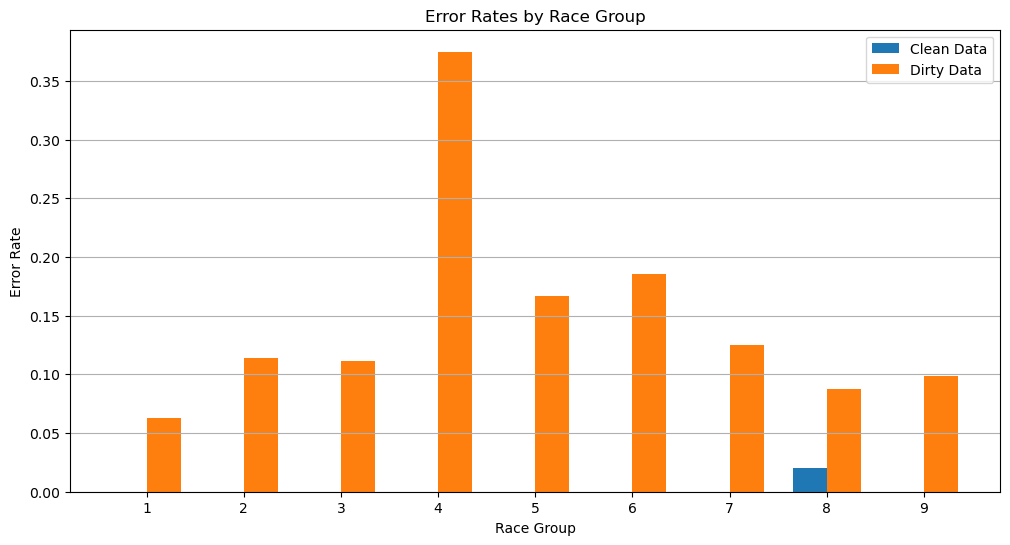

In [36]:
# Function to identify and analyze misclassified examples
def analyze_misclassifications(X_test, y_test, y_pred, sensitive_attr):
    # Find misclassified examples
    misclassified = (y_test != y_pred)
    X_misclassified = X_test[misclassified]
    y_true_misclassified = y_test[misclassified]
    s_misclassified = sensitive_attr[misclassified]
    
    # Count misclassifications by group
    group_counts = s_misclassified.value_counts().to_dict()
    total_by_group = sensitive_attr.value_counts().to_dict()
    
    # Calculate error rates by group
    error_rates = {g: group_counts.get(g, 0) / total_by_group.get(g, 1) for g in total_by_group}
    
    # Analyze feature distributions of misclassified examples
    misclassified_stats = X_misclassified.describe()
    overall_stats = X_test.describe()
    
    return {
        'total_misclassified': misclassified.sum(),
        'error_rate': misclassified.mean(),
        'group_error_counts': group_counts,
        'group_error_rates': error_rates,
        'misclassified_feature_stats': misclassified_stats,
        'overall_feature_stats': overall_stats
    }

# Apply to both models on both datasets
logreg_clean_errors = analyze_misclassifications(X_test_clean, y_test_clean, y_pred_clean, s_test_clean)
logreg_dirty_errors = analyze_misclassifications(X_test_dirty, y_test_dirty, y_pred_dirty, s_test_dirty)
tree_clean_errors = analyze_misclassifications(X_test_clean, y_test_clean, y_pred_tree_clean, s_test_clean)
tree_dirty_errors = analyze_misclassifications(X_test_dirty, y_test_dirty, y_pred_tree_dirty, s_test_dirty)

# Visualize error rates by group
groups = sorted(set(logreg_clean_errors['group_error_rates'].keys()) | 
                set(logreg_dirty_errors['group_error_rates'].keys()))
clean_errors = [logreg_clean_errors['group_error_rates'].get(g, 0) for g in groups]
dirty_errors = [logreg_dirty_errors['group_error_rates'].get(g, 0) for g in groups]

plt.figure(figsize=(12, 6))
x = np.arange(len(groups))
width = 0.35
plt.bar(x - width/2, clean_errors, width, label='Clean Data')
plt.bar(x + width/2, dirty_errors, width, label='Dirty Data')
plt.xlabel('Race Group')
plt.ylabel('Error Rate')
plt.title('Error Rates by Race Group')
plt.xticks(x, groups)
plt.legend()
plt.grid(True, axis='y')
plt.show()